In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
date = session.query(Measurement.date).filter(Measurement.date).order_by(Measurement.date.desc()).first()
date_time = dt.datetime.strptime(date[0], '%Y-%m-%d')
query_date = date_time-dt.timedelta(days=365)
rain = session.query(Measurement.date, Measurement.prcp).filter(func.strftime("%Y-%m-%d", Measurement.date) >= query_date).order_by(Measurement.date).all()

prcp_df = pd.DataFrame(rain)
rename=prcp_df.rename(columns = {"prcp":"precipitation"})
precipitation_df = rename.set_index("date")

<Figure size 432x288 with 0 Axes>

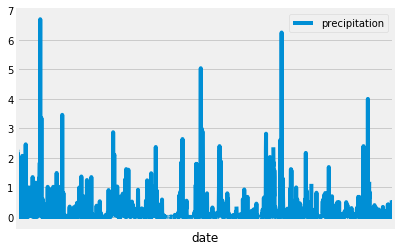

In [11]:
plt.figure()
precipitation_df.plot()
plt.xticks([])
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
new = pd.DataFrame(precipitation_df["precipitation"].describe())
new

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
stations = pd.DataFrame(session.query(Station.station, Station.name).all())
stations["station"].count()

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
# session.query(Measurement, Station).filter(Measurement.station == Station.station).group_by(Measurement.station).all()
activity = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()
activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).first()
ma_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active[0]).all()
ma_min = ma_stats[0][0]
ma_max = ma_stats[0][1]
ma_avg = round(ma_stats[0][2],1)
print(f"At the most active station, the minimum temp recorded is {ma_min} degrees, the highest is {ma_max} degrees, and the average is {ma_avg} degrees.")

At the most active station, the minimum temp recorded is 54.0 degrees, the highest is 85.0 degrees, and the average is 71.7 degrees.


In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_tobs = session.query(Measurement.station, func.count(Measurement.tobs)).filter(Measurement.tobs != "Null").group_by(Measurement.station).order_by(desc(func.count(Measurement.tobs))).all()
tobs_12_mo = session.query(Measurement.tobs).filter((func.strftime("%Y-%m-%d", Measurement.date) >= query_date) & (Measurement.station == most_tobs[0][0])).all()

<Figure size 432x288 with 0 Axes>

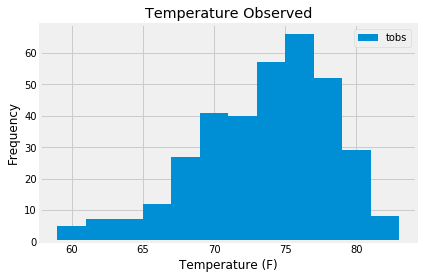

In [37]:
tobs_df = pd.DataFrame(tobs_12_mo)
temp_df=tobs_df.rename(columns = {"tobs":"Temperature Observed"})

plt.figure()
temp_df.hist(bins=12, label="tobs")
plt.ylabel("Frequency")
plt.xlabel("Temperature (F)")
plt.legend()
plt.show()


In [39]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [44]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

calc_results = (calc_temps('2011-02-28','2011-03-05'))[0]
calc_results
min_result = calc_results[0]
avg_result = calc_results[1]
max_result = calc_results[2]
print(f"{min_result} {avg_result} {max_result}")

61.0 69.75510204081633 75.0


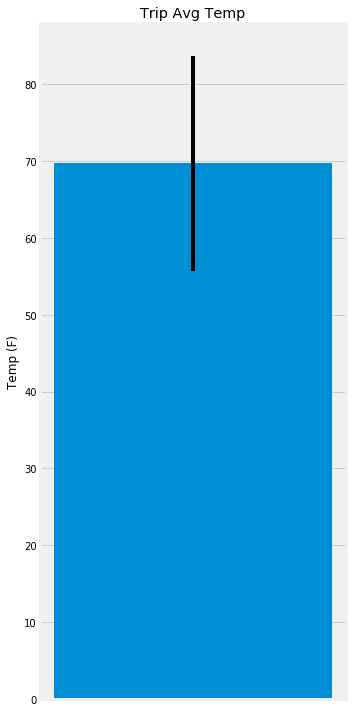

In [58]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error_bar = max_result - min_result

fig, ax = plt.subplots(figsize = (5, 10))

ax.bar(0, avg_result, yerr = error_bar)

ax.set_xticks([])
ax.set_title('Trip Avg Temp')
ax.set_ylabel('Temp (F)')

plt.tight_layout()
plt.show()

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
